In [12]:
torch.__version__

'2.5.1'

In [62]:
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# Константы
num_trajectories = 100  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'data'  # Путь к данным
input_features = ['x_measure', 'y_measure', 'z_measure', 'v_x_measure_extr', 'v_y_measure_extr', 'v_z_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']  # Входные признаки
target_feature = 'x_true'  # Целевая координата

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, num_radars, seq_length)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Теперь транспонируем X_data, y_data чтобы размерность стала (num_trajectories * num_radars, seq_length, num_features)
X_data = X_data.reshape(-1, X_data.shape[2], X_data.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
y_data = y_data.reshape(-1, y_data.shape[2])  # (num_trajectories * num_radars, seq_length)

# Проверим размерность данных
print(X_data.shape)  # (1600, seq_length, num_features) 
print(y_data.shape)  # (1600, seq_length)


device:  cuda
(1600, 101, 9)
(1600, 101)


In [63]:


class RadarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_size = int(0.8 * num_trajectories * num_radars)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Создаем DataLoader
batch_size = 16  # Один батч — 16 различных реализаций от радаров для одной траектории
train_dataset = RadarDataset(X_train, y_train)
test_dataset = RadarDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Не перемешиваем данные
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Пример батча
for X_batch, y_batch in train_loader:
    print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
    print(y_batch.shape)  # (16, seq_length)
    break


torch.Size([16, 101, 9])
torch.Size([16, 101])


------------------------------------------------------------------------------ MODEL ------------------------------------------------------------------------------

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)  # Выходной слой для регрессии

    def forward(self, x):
        # LSTM: возвращает все временные шаги и последний скрытый слой
        out, (hidden, _) = self.lstm(x)
        # Выбираем последнее состояние и пропускаем через линейный слой
        return self.fc(hidden[-1])

In [65]:
def train_model(model, train_loader, optimizer, criterion, num_epochs, print_flag=True):
    history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # print(X_batch.shape, y_batch.shape)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
            # Обнуление градиентов
            optimizer.zero_grad()
    
            # Прямой проход
            outputs = model(X_batch)
            outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости
    
            # Проверяем размерность целевого тензора
            if len(y_batch.shape) > 1:
                y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения
    
            # Вычисляем потери
            loss = criterion(outputs, y_batch)
    
            # Обратный проход
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
    
        # Среднее значение потерь за эпоху
        train_loss /= len(train_loader)
        history.append(train_loss)
        if print_flag:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
    return model, history

In [66]:
10**5//1000

100

In [67]:
%%time

# Параметры модели
input_size = X_data.shape[2]  # Число входных признаков
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
trained_model, training_history = train_model(model, train_loader, optimizer, criterion, num_epochs, print_flag=True)

Epoch [1/200], Loss: 65893.2392
Epoch [2/200], Loss: 62710.9569
Epoch [3/200], Loss: 59267.8579
Epoch [4/200], Loss: 56290.8773
Epoch [5/200], Loss: 53685.6046
Epoch [6/200], Loss: 51185.6756
Epoch [7/200], Loss: 48878.1556
Epoch [8/200], Loss: 46714.7649
Epoch [9/200], Loss: 44672.0997
Epoch [10/200], Loss: 42726.3041
Epoch [11/200], Loss: 40862.4996
Epoch [12/200], Loss: 39077.0801
Epoch [13/200], Loss: 37363.8049
Epoch [14/200], Loss: 35718.1409
Epoch [15/200], Loss: 34135.5797
Epoch [16/200], Loss: 32614.1105
Epoch [17/200], Loss: 31151.5042
Epoch [18/200], Loss: 29743.8379
Epoch [19/200], Loss: 28389.6165
Epoch [20/200], Loss: 27087.9612
Epoch [21/200], Loss: 25836.5016
Epoch [22/200], Loss: 24632.9440
Epoch [23/200], Loss: 23476.5732
Epoch [24/200], Loss: 22365.7618
Epoch [25/200], Loss: 21298.9271
Epoch [26/200], Loss: 20275.5278
Epoch [27/200], Loss: 19293.7769
Epoch [28/200], Loss: 18352.5877
Epoch [29/200], Loss: 17450.8100
Epoch [30/200], Loss: 16587.6265
Epoch [31/200], Los

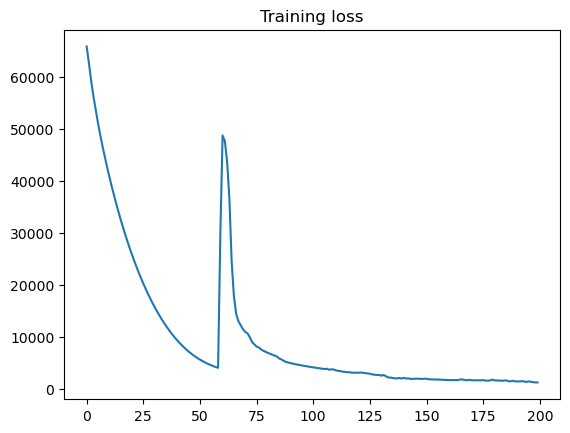

In [68]:
plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

In [69]:
# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()
        

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 2176.0335


In [ ]:
# -----------------------------------------------------------------------------------------

In [49]:
import numpy as np
import os
import pandas as pd

# Константы
num_trajectories = 100  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'data'  # Путь к данным
input_features = ['x_measure', 'v_x_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']  # Входные признаки
target_feature = 'x_true'  # Целевая координата

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, seq_length)

# Теперь транспонируем X_data, y_data чтобы размерность стала (num_trajectories * num_radars, seq_length, num_features)
# print(X_data.shape[3])
X_data = X_data.reshape(-1, X_data.shape[2], X_data.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
y_data = y_data.reshape(-1, y_data.shape[2])

# Проверим размерность данных
print(X_data.shape)  # (100, 16, seq_length, num_features)
print(y_data.shape)  # (100, seq_length)


(1600, 101, 5)
(1600, 101)


In [43]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Полносвязный слой для регрессии
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Проход через LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Берем последний выход для предсказания
        out = out[:, -1, :]  # Последний временной шаг
        out = self.fc(out)  # Регрессия для получения предсказания координаты
        
        return out

# Инициализация модели
model = LSTMModel(input_size=len(input_features), hidden_size=64, num_layers=2)

# Использование на GPU, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
from torch.utils.data import DataLoader, TensorDataset

# Преобразуем данные в тензоры PyTorch
X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)

# Изменим размерность данных, чтобы у нас было (num_trajectories * num_radars, seq_length, num_features)
X_tensor = X_tensor.view(-1, X_tensor.shape[2], X_tensor.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
y_tensor = y_tensor.view(-1, y_tensor.shape[2])  # (num_trajectories * num_radars, seq_length)

# Создаем TensorDataset и DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Цикл обучения
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(X_batch)
        
        # Вычисление потерь
        loss = criterion(outputs, y_batch)  # Убираем лишнюю размерность
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")


torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])


D:\Diplom\air_estimating_by_several_radars\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 101])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([1

In [15]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Параметры
num_radars = 16
num_trajectories = 100
input_features = ['x_measure', 'v_x_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']
target_feature = 'x_true'
data_path = 'data/'

# Функция для загрузки данных одной траектории
def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси
    traj_data = pd.concat(trajectory_data, axis=0).reset_index(drop=True)
    return traj_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    data = load_trajectory_data(traj_idx)
    X = data[input_features].values  # Входные данные
    y = data[target_feature].values  # Истинная координата
    X_data.append(X)
    y_data.append(y)

# Конвертируем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, seq_length)
print(X_data.shape)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)


# Делим на тренировочную и тестовую выборки
train_size = int(0.8 * num_trajectories)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Кастомный Dataset для PyTorch
class RadarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаем DataLoader
batch_size = 1  # Один батч — одна траектория от всех радаров
train_dataset = RadarDataset(X_train, y_train)
test_dataset = RadarDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


(100, 1616, 5)


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Выходной слой для регрессии

    def forward(self, x):
        # LSTM: возвращает все временные шаги и последний скрытый слой
        out, (hidden, _) = self.lstm(x)
        # Выбираем последнее состояние и пропускаем через линейный слой
        return self.fc(hidden[-1])

# Параметры модели
input_size = len(input_features)  # Число входных признаков
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)


device:  cpu
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])


D:\Diplom\air_estimating_by_several_radars\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 57319.4002


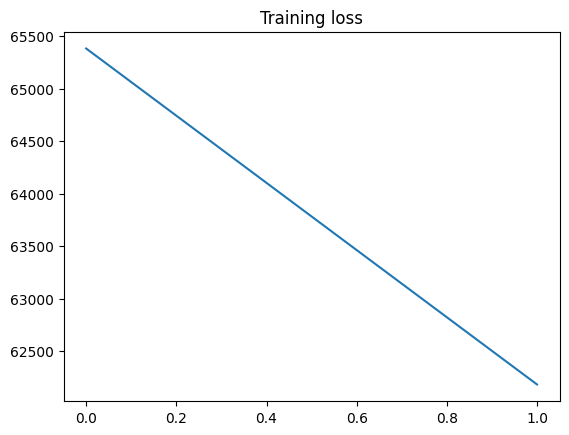

CPU times: total: 2min 27s
Wall time: 14.8 s


In [14]:
%%time
# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device: ", device)

# Обучение
num_epochs = 2
history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(X_batch)
        outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости

        # Проверяем размерность целевого тензора
        if len(y_batch.shape) > 1:
            y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения

        # Вычисляем потери
        loss = criterion(outputs, y_batch)

        # Обратный проход
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Вычисляем среднее значение потерь за эпоху
    train_loss /= len(train_loader)
    history.append(train_loss)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

plt.plot(np.arange(num_epochs), history)
plt.title("Training loss")
plt.show()

In [5]:
%%time
# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device: ", device)

# Обучение
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(X_batch)
        outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости

        # Проверяем размерность целевого тензора
        if len(y_batch.shape) > 1:
            y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения

        # Вычисляем потери
        loss = criterion(outputs, y_batch)

        # Обратный проход
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Вычисляем среднее значение потерь за эпоху
    train_loss /= len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


device:  cpu
Epoch [1/100], Loss: 65310.1636
Epoch [2/100], Loss: 62085.6763
Epoch [3/100], Loss: 58659.6536
Epoch [4/100], Loss: 55790.7667
Epoch [5/100], Loss: 53297.2489
Epoch [6/100], Loss: 50992.2295
Epoch [7/100], Loss: 48817.4113
Epoch [8/100], Loss: 46750.3469
Epoch [9/100], Loss: 44772.7603
Epoch [10/100], Loss: 42881.0486
Epoch [11/100], Loss: 41060.8761
Epoch [12/100], Loss: 39306.3765
Epoch [13/100], Loss: 37619.2231
Epoch [14/100], Loss: 35993.9506
Epoch [15/100], Loss: 34424.0276
Epoch [16/100], Loss: 32914.9060
Epoch [17/100], Loss: 31458.2173
Epoch [18/100], Loss: 30057.4309
Epoch [19/100], Loss: 28708.0938
Epoch [20/100], Loss: 27409.0876
Epoch [21/100], Loss: 26160.7731
Epoch [22/100], Loss: 24957.3623
Epoch [23/100], Loss: 23801.0492
Epoch [24/100], Loss: 22686.8096
Epoch [25/100], Loss: 21621.5690
Epoch [26/100], Loss: 20596.7670
Epoch [27/100], Loss: 19607.3759
Epoch [28/100], Loss: 18663.9536
Epoch [29/100], Loss: 17758.7482
Epoch [30/100], Loss: 16885.9193
Epoch 

C:\Users\lamin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2123.0420
